In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from tqdm import tqdm
import ot
from scipy.spatial.distance import pdist, squareform
from sklearn import manifold
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

from helper_functions import *

maindir = "/Users/hieunguyen/data/WGS_features"
outdir = "/Users/hieunguyen/data/outdir"
data_version = "20240822"
PROJECT = "WGS_feature_dist_distance"
output_version = "20240822"
feature_name = "Nucleosome"

path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_02_output = os.path.join(path_to_main_output, "02_output")

os.system("mkdir -p {}".format(path_to_02_output))

metadata = pd.read_csv(os.path.join(path_to_01_output, "metadata.filtered.csv"))
controldf = pd.read_csv(os.path.join(path_to_01_output, "Control.{}.csv".format(feature_name)), index_col = [0])

sample_list = dict()
for run in metadata.Run.unique():
    sample_list[run] = metadata[(metadata.Run == run) & (metadata.Label == "Control")].SampleID.tolist()

In [2]:
##### define training runs and testing runs, any run before R5253 is used for training, the rest is used for testing
training_run = ['R5044',
                'R5063',
                'R5083',
                'R5097',
                'R5119',
                'R5151',
                'R5167',
                'R5168',
                'R5169',
                'R5170',
                'R5184',
                'R5201',
                'R5219',
                'R5253']
training_samples = metadata[(metadata['Run'].isin(training_run)) & (metadata["Label"] == "Control")]["SampleID"].unique()
testing_samples = metadata[(~metadata['Run'].isin(training_run)) & (metadata["Label"] == "Control")]["SampleID"].unique()
controldf_train = controldf[training_samples].copy()
controldf_test = controldf[testing_samples].copy()

In [3]:
##### calculate the bary center for training samples
training_barycenter = calculate_barycenter(A = controldf_train.to_numpy(), n = 601)

(0.0, 1.0)

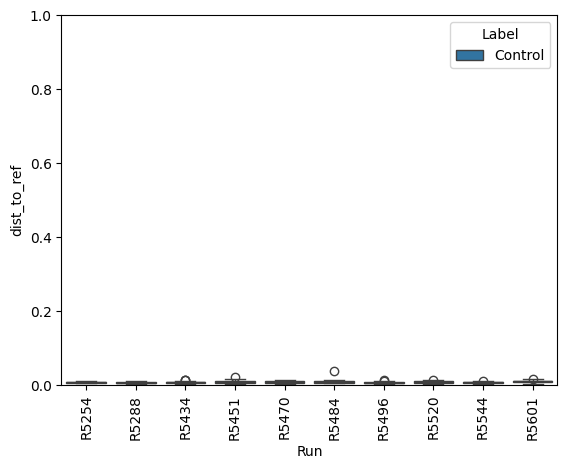

In [4]:
##### caclulate the OT distance from testing samples to "training samples" barycenter
testdf = pd.DataFrame(data = testing_samples, columns=["SampleID"])
testdf = testdf.merge(metadata[["SampleID", "Label", "Run"]], right_on = "SampleID", left_on = "SampleID")
testdf["dist_to_ref"] = testdf["SampleID"].apply(lambda x: calculate_ot_distance_to_ref(x, training_barycenter, controldf_test, 601))
sns.boxplot(data = testdf, x = "Run", y = "dist_to_ref", hue = "Label")
plt.xticks(rotation=90)
plt.ylim([0, 0.2])

(0.0, 1.0)

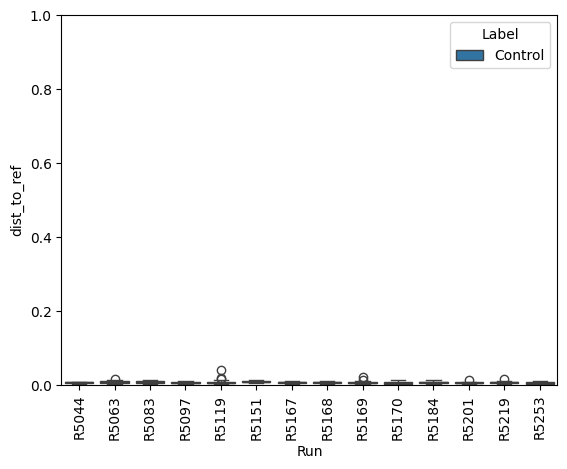

In [5]:
##### caclulate the OT distance from testing samples to "training samples" barycenter
traindf = pd.DataFrame(data = training_samples  , columns=["SampleID"])
traindf = traindf.merge(metadata[["SampleID", "Label", "Run"]], right_on = "SampleID", left_on = "SampleID")
traindf["dist_to_ref"] = traindf["SampleID"].apply(lambda x: calculate_ot_distance_to_ref(x, training_barycenter, controldf_train, 601))
sns.boxplot(data = traindf, x = "Run", y = "dist_to_ref", hue = "Label")
plt.xticks(rotation = 90)
plt.ylim([0, 0.2])

In [6]:
# ##### generate a pairwise distance matrix and apply MDS
# otdistdf = pdist(X = controldf.T.to_numpy(), metric=ot_distance)

# mds = manifold.MDS(
#     n_components=2,
#     max_iter=3000,
#     eps=1e-9,
#     random_state=411,
#     dissimilarity="precomputed",
#     n_jobs=1,
# )
# pos = mds.fit(squareform(otdistdf)).embedding_
# mdsdf = pd.DataFrame(data = pos, columns = ["x", "y"])
# mdsdf["SampleID"] = controldf.columns
# mdsdf = mdsdf.merge(metadata[["SampleID", "Label", "Run"]], right_on = "SampleID", left_on = "SampleID")
# sns.scatterplot(data = mdsdf, x = "x", y = "y", hue = "Run", style = "Label", legend = False)


In [7]:
run_barycenterdf = pd.DataFrame()
for run in tqdm(sample_list.keys()):
    tmpdf = pd.DataFrame(data = calculate_barycenter(controldf[sample_list[run]].to_numpy(), show_plot = False, n = 601), columns = [run])
    run_barycenterdf = pd.concat([run_barycenterdf, tmpdf], axis = 1)
    
# calculate the variance at each point
run_barycenterdf["variance"] = run_barycenterdf.var(axis = 1)

# get top 5 highest variance
top_var = run_barycenterdf.sort_values(by = "variance", ascending = False).head(10).index

100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


<Axes: >

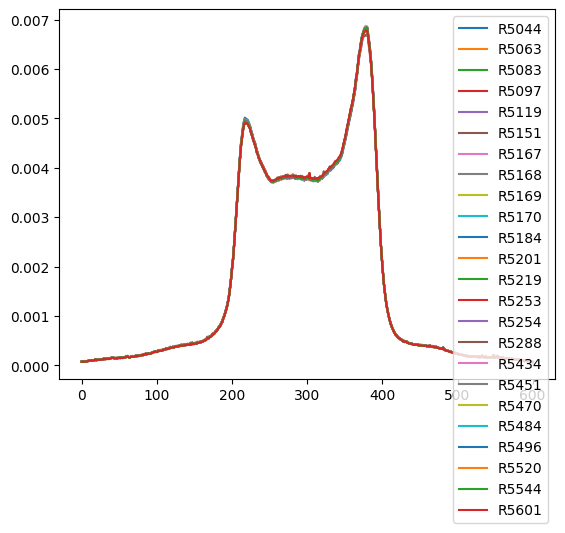

In [8]:
##### show all RUNS barycenter
run_barycenterdf.drop("variance", axis = 1).plot()

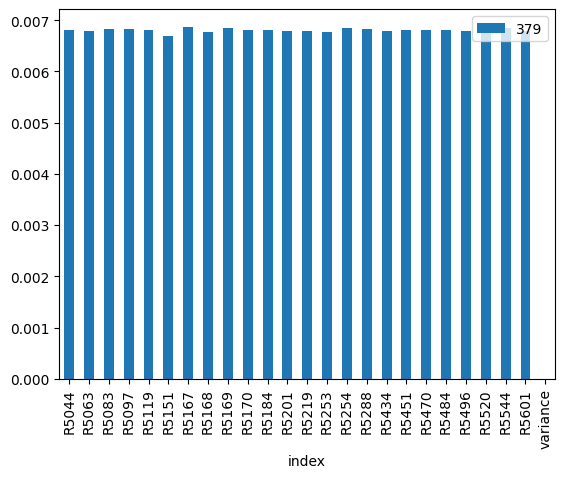

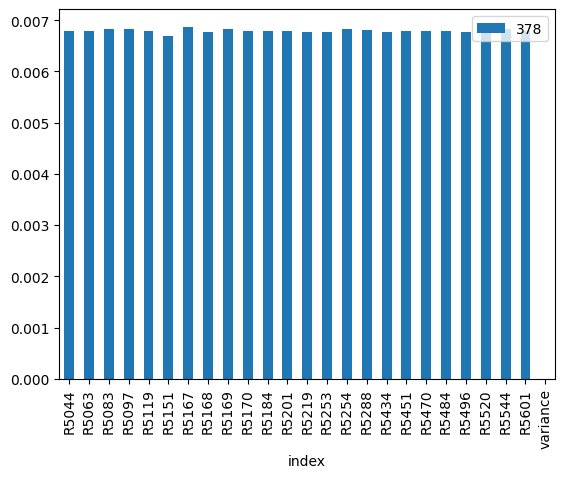

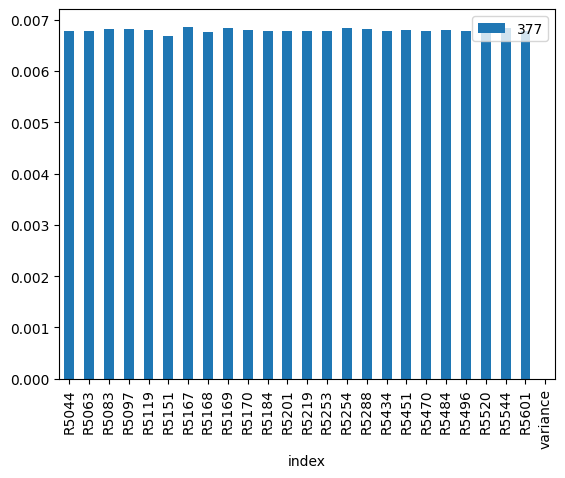

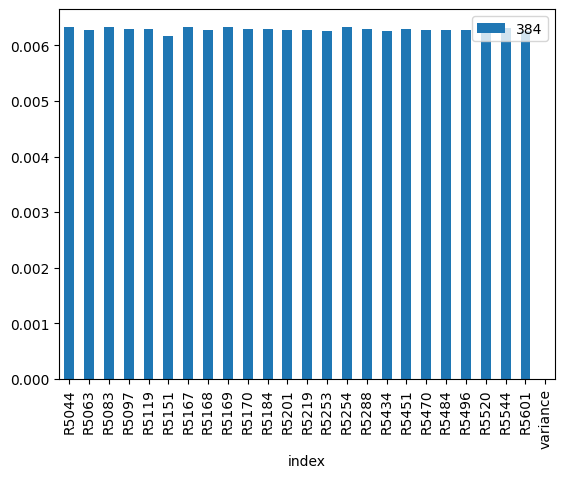

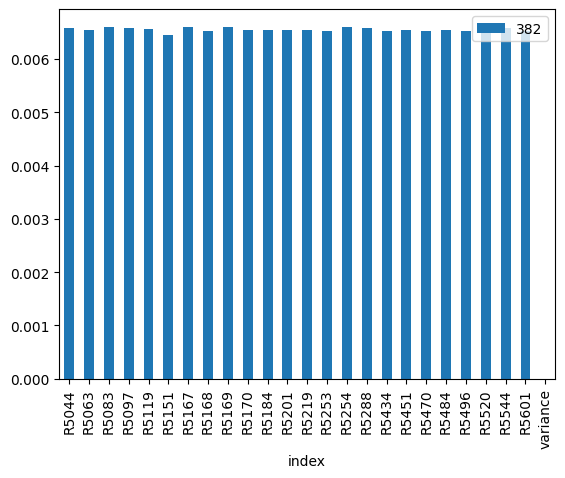

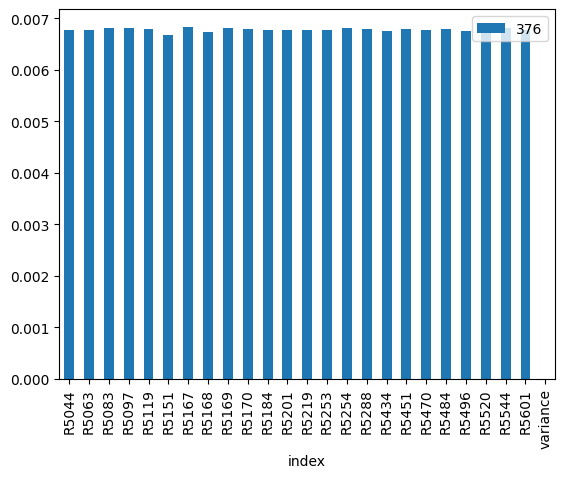

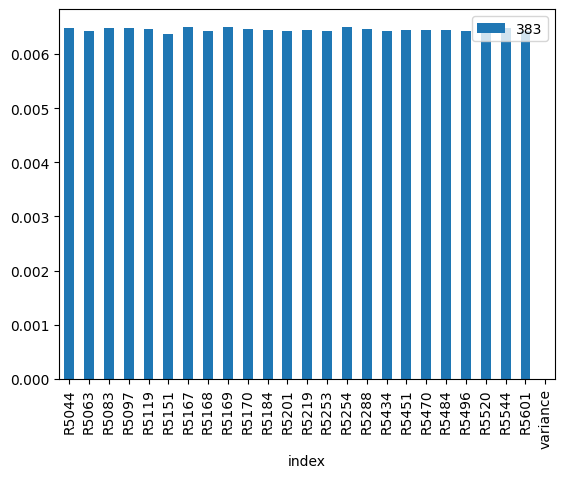

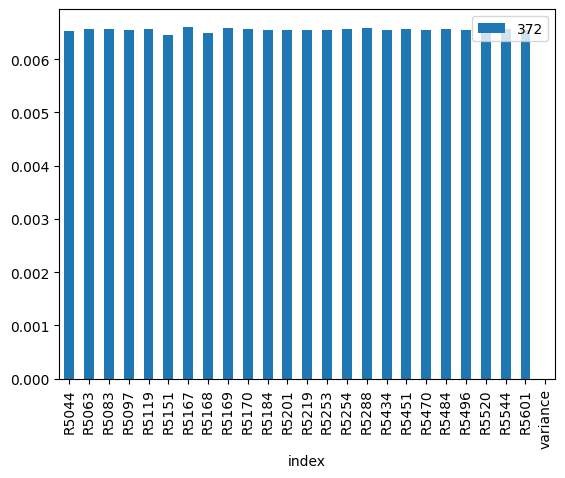

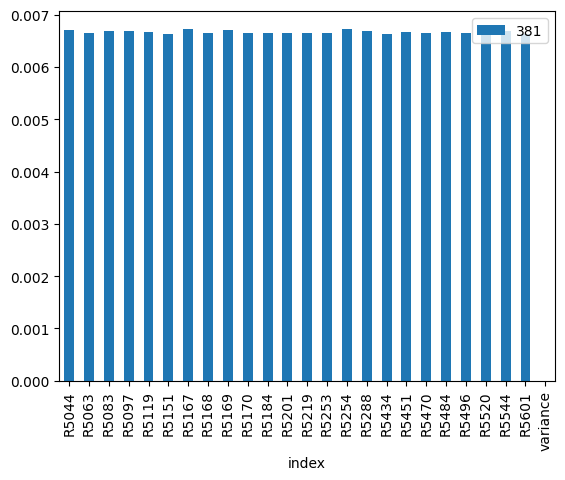

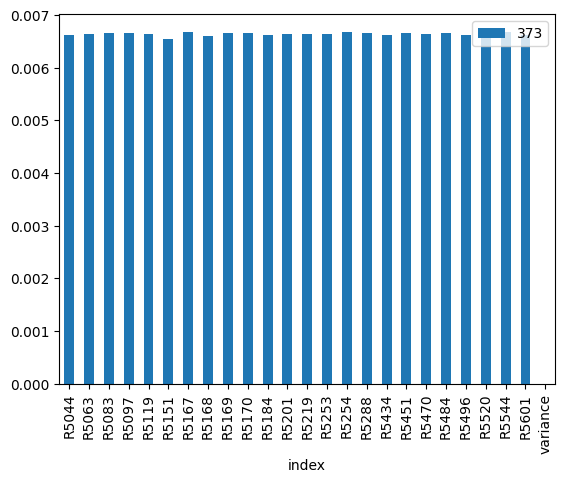

In [9]:
for i in range(len(top_var)):
    run_barycenterdf.loc[top_var[i]].reset_index().plot( x= "index", kind = "bar")
    plt.show()